In [1]:
# import packages 
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.dates as mdates
from modelutility_v2 import *

%matplotlib inline

# folder path and name
project_path = os.getcwd()
target_folder = 'target'
target_file = 'huang.csv'
output_folder = 'plot'
image_folder = 'E:\\snapshot_archive'
cardinal = '#8c1515'

# matplotlib style path
style_path = os.path.join(project_path,output_folder,'stanford.mplstyle')
# plt.style.use('seaborn')
plt.style.use(style_path)
kw_btuhr=3412.142
box_widths = 0.7 
num_rep = 10

# baseline paramenters
baseline_freq = 2
baseline_num_lag = 16
baseline_interval = 60 # seconds


## Calculate MSE of Persistence model

In [2]:
baseline_data_folder = os.path.join('data_pred_expanded','frequency_2')
first_cloudy_test = datetime.datetime(2018,2,18)

## Obtain persistence model loss
#define file location
pv_log_trainval_path = os.path.join(baseline_data_folder,'pv_log_trainval.npy')
pv_pred_trainval_path = os.path.join(baseline_data_folder,'pv_pred_trainval.npy')

pv_log_test_path = os.path.join(baseline_data_folder,'pv_log_test.npy')
pv_pred_test_path = os.path.join(baseline_data_folder,'pv_pred_test.npy')
times_test_path = os.path.join(baseline_data_folder,'times_test.npy')
times_trainval_path = os.path.join(baseline_data_folder,'times_trainval.npy')

# load PV output and images for the test
pv_log_test = np.load(pv_log_test_path)
pv_pred_test = np.load(pv_pred_test_path)
times_test = np.load(times_test_path)

# load PV output and images for the trainval set
pv_log_trainval = np.load(pv_log_trainval_path)
pv_pred_trainval = np.load(pv_pred_trainval_path)
times_trainval = np.load(times_trainval_path)

#Find the index of the first rainy day.
first_cloudy_idx = find_idx_with_dates(times_test, [first_cloudy_test])[0]

# Find the MSE of the persistence model on trainval set
pers_mse_trainval = np.mean(np.square(pv_pred_trainval - pv_log_trainval[:,0]))
pers_mse_test = np.mean(np.square(pv_pred_test - pv_log_test[:,0]))
print('Persistence MSE of the trainval set: {0:.2f},test set: {1:.2f}'.format(pers_mse_trainval,pers_mse_test))

# Find the MSE of the persistence model on test set
pers_mse_sunny_test = np.mean(np.square(pv_pred_test - pv_log_test[:,0])[:first_cloudy_idx])
pers_mse_cloudy_test = np.mean(np.square(pv_pred_test - pv_log_test[:,0])[first_cloudy_idx:])
print('Persistence MSE of the sunny test set: {0:.2f},cloudy test set: {1:.2f}'
      .format(pers_mse_sunny_test,pers_mse_cloudy_test))

Persistence MSE of the trainval set: 6.37,test set: 9.60
Persistence MSE of the sunny test set: 1.38,cloudy test set: 16.27


# Calculate MSE of kt - Persistence model


In [3]:
from Relative_op_func2 import Relative_output

# calculate the kt of the current time
kt_test,pv_log_test_theo = Relative_output(times_test, pv_log_test[:,0]) 
kt_trainval,pv_log_trainval_theo = Relative_output(times_trainval, pv_log_trainval[:,0]) 
# kt = pv_log_test[:,0]/pv_log_test_theo

# calculate the P_theo in the future time
_,pv_pred_test_theo = Relative_output(times_test + datetime.timedelta(minutes = 15), pv_pred_test)
_,pv_pred_trainval_theo = Relative_output(times_trainval + datetime.timedelta(minutes = 15), pv_pred_trainval)

# forecast with kt_persistence
pv_pred_test_ktpers = kt_test*pv_pred_test_theo
pv_pred_trainval_ktpers = kt_trainval*pv_pred_trainval_theo


# Find the MSE of the persistence model on trainval set
ktpers_mse_trainval = np.mean(np.square(pv_pred_trainval - pv_pred_trainval_ktpers))
ktpers_mse_test = np.mean(np.square(pv_pred_test - pv_pred_test_ktpers))
print('kt-Persistence MSE of the trainval set: {0:.2f},test set: {1:.2f}'
      .format(ktpers_mse_trainval,ktpers_mse_test))

# Find the MSE of the persistence model on test set
ktpers_mse_sunny_test = np.mean(np.square(pv_pred_test - pv_pred_test_ktpers)[:first_cloudy_idx])
ktpers_mse_cloudy_test = np.mean(np.square(pv_pred_test -  pv_pred_test_ktpers)[first_cloudy_idx:])

print('kt-Persistence MSE of the sunny test set: {0:.2f},cloudy test set: {1:.2f}'
      .format(ktpers_mse_sunny_test,ktpers_mse_cloudy_test))

ktpers_mse_all = (ktpers_mse_trainval*times_trainval.size+ktpers_mse_test*times_test.size)/(
    times_trainval.size + times_test.size)

sunny_fraction = (ktpers_mse_all-ktpers_mse_cloudy_test)/(ktpers_mse_sunny_test-ktpers_mse_cloudy_test)
print('fraction of sunny day is: {0:.2f},cloudy day is: {1:.2f}'.format(sunny_fraction, 1-sunny_fraction))

kt-Persistence MSE of the trainval set: 5.59,test set: 8.87
kt-Persistence MSE of the sunny test set: 0.46,cloudy test set: 15.69
fraction of sunny day is: 0.64,cloudy day is: 0.36


# Calculate MSE of SUNSET model 

In [4]:
# load in sunset prediction
model = 'CNN_1.0_Baseline'
pv_pred_test_sunset = np.load(os.path.join('models',model,"pred_test.npy"))

# Find the MSE of the persistence model on test set
sunset_mse_sunny_test = np.mean(np.square(pv_pred_test - pv_pred_test_sunset)[:first_cloudy_idx])
sunset_mse_cloudy_test = np.mean(np.square(pv_pred_test - pv_pred_test_sunset)[first_cloudy_idx:])

print('kt-Persistence MSE of the sunny test set: {0:.2f},cloudy test set: {1:.2f}'
      .format(sunset_mse_sunny_test,sunset_mse_cloudy_test))

print('Sunny Forecast skill: {0:.4f}, Cloudy: {1:.4f}'
      .format(1 - np.sqrt(sunset_mse_sunny_test/ktpers_mse_sunny_test), 
              1 - np.sqrt(sunset_mse_cloudy_test/ktpers_mse_cloudy_test)))



kt-Persistence MSE of the sunny test set: 0.54,cloudy test set: 10.98
Sunny Forecast skill: -0.0825, Cloudy: 0.1634


# Utility for finding the best error for each hyper-parameter or fold 

In [5]:
def find_best_error(output_folder):
    # Restore error history
    train_error = np.load(os.path.join(output_folder,"train_error.npy"))
    val_error = np.load(os.path.join(output_folder,"val_error.npy"))
    
    num_rep = train_error.shape[0]
    
    # Only obtain results for best model
    best_idx = np.zeros(num_rep,dtype =int)
    for i in range(num_rep):
        best_idx[i] = np.argmin(val_error[i][val_error[i]>0])

    train_best = train_error[np.arange(num_rep),best_idx] 
    val_best = val_error[np.arange(num_rep),best_idx]
    
    return [train_best,val_best]

def find_best_loss(output_folder):
    # Restore error history
    train_error = np.load(os.path.join(output_folder,"train_loss.npy"))
    val_error = np.load(os.path.join(output_folder,"val_loss.npy"))
    
    num_rep = train_error.shape[0]
    
    # Only obtain results for best model
    best_idx = np.zeros(num_rep,dtype =int)
    for i in range(num_rep):
        best_idx[i] = np.argmin(val_error[i][val_error[i]>0])

    train_best = train_error[np.arange(num_rep),best_idx] 
    val_best = val_error[np.arange(num_rep),best_idx]
    
    return [train_best,val_best]

## Common utility for finding best performing model among the sensitivity analysis
def find_best_multiexp(val_loss):

    val_best_loss = np.zeros((val_loss.shape[0],val_loss.shape[1]))

    for i in range(val_loss.shape[0]):
        for j in range(val_loss.shape[1]):
            val_best_loss[i,j] = np.amin(val_loss[i,j][val_loss[i,j]>0])
            
    return val_best_loss

# 1 Example Images and PV output
## 1.1 Example Images: sunny and cloudy

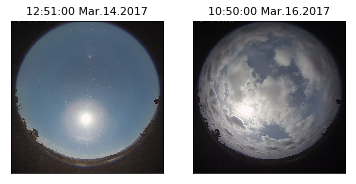

In [6]:
## Take a sunny day and cloudy day and put two snaps together

sunny_image_path = os.path.join(image_folder,'20170314125100.jpg')
cloudy_image_path = os.path.join(image_folder,'20170316105000.jpg')

sunny_image = cv2.imread(sunny_image_path)
cloudy_image = cv2.imread(cloudy_image_path)

plt.subplot(121)
plt.title('12:51:00 Mar.14.2017')
plt.xticks([])
plt.yticks([])
plt.imshow(sunny_image[:,:,::-1])


plt.subplot(122)
plt.title('10:50:00 Mar.16.2017')
plt.xticks([])
plt.yticks([])
plt.imshow(cloudy_image[:,:,::-1])

plt.savefig(os.path.join(output_folder,'sky_images_eg.png'), bbox_inches='tight',dpi=300,transparent = True)
plt.show()


# 2 Results
## 2.0 Baseline 
### 2.0.1 Uncertainty of the Mean loss

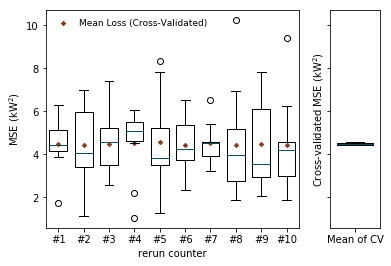

Standard deviation of the mean loss is 0.041


In [8]:
## Set up a three panel plot, for the three experiment 
fig, axarr = plt.subplots(1,2, sharey = True,
                         gridspec_kw = {'width_ratios':[5,1]})

## Number of lag terms
hundred_rep_folders = ['CNN_1.0_Baseline_reps_{0}_to_{1}'.format(10*i+1, 10*i+10) for i in range(10)]

## initialize a folder to store all validation loss
val_loss = np.zeros((10,10,100))

for i,folder in enumerate(hundred_rep_folders):
    val_loss[i] = np.load(os.path.join('models','100_rep_models',folder,'val_loss.npy'))

val_best_loss  = find_best_multiexp(val_loss)

# Plot the 10 boxplot for each of the CV experiment
ax = axarr[0]
exp_names = ['#' + str(i) for i in range(1,11)]

ax.boxplot(val_best_loss.T,labels = exp_names, widths= box_widths)
ax.set_xlabel('rerun counter')
ax.set_ylabel('MSE ($\mathrm{kW}^2$)')

# plot the much more stable mean loss
val_mean_loss = np.mean(val_best_loss,axis = 1)
ax.scatter(np.arange(1,11),val_mean_loss, marker = 'D', label = 'Mean Loss (Cross-Validated)')
ax.legend()

# plot the mean loss separately in a box plot to the right
ax = axarr[1]
ax.boxplot(val_mean_loss, labels = ['Mean of CV'], widths= box_widths)
ax.set_ylabel('Cross-validated MSE ($\mathrm{kW}^2$)')

# saving and showing figure
plt.savefig(os.path.join(output_folder,'val_loss_uncertainty.pdf'),bbox_inches = 'tight')
plt.show()

# Output the standard deviation of mean loss
mean_loss_std = np.std(val_mean_loss)
print("Standard deviation of the mean loss is {0:.3f}".format(mean_loss_std))

### 2.0.2 Parity Graph 

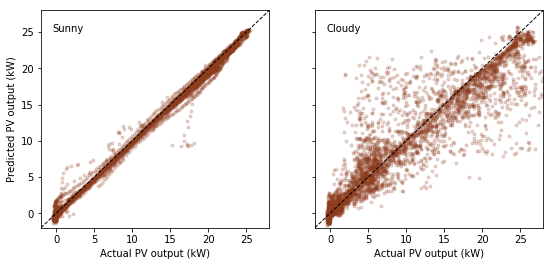

In [9]:
# Read in the prediction
model_name = 'CNN_1.0_Baseline'
pred_test = np.load(os.path.join('models',model_name,'pred_test.npy'))
truth_test = np.load(os.path.join('data_pred_expanded','frequency_2','pv_pred_test.npy'))

#Find the index of the first rainy day.
first_cloudy_idx = find_idx_with_dates(times_test, [first_cloudy_test])[0]

# Plotting for the sunny and cloudy situation
fig,axarr = plt.subplots(1,2, sharey = True)
conditions = ['Sunny','Cloudy']

for i,ax in enumerate(axarr):
    ax.set_xlim(-2,28)
    ax.set_ylim(-2,28)
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color = 'k')
    
    if i==0:
        ax.scatter(truth_test[:first_cloudy_idx],pred_test[:first_cloudy_idx], alpha = 0.2)
    else:
        ax.scatter(truth_test[first_cloudy_idx:],pred_test[first_cloudy_idx:], alpha = 0.2)
    ax.text(0.05,0.9,conditions[i], transform=ax.transAxes)
    ax.set_xlabel('Actual PV output (kW)')


axarr[0].set_ylabel('Predicted PV output (kW)')

# Save the figure
fig.set_size_inches(9,4)
plt.savefig(os.path.join(output_folder,'parity_baseline.pdf'),bbox_inches = 'tight')
plt.show()

### 2.0.2 Error distribution

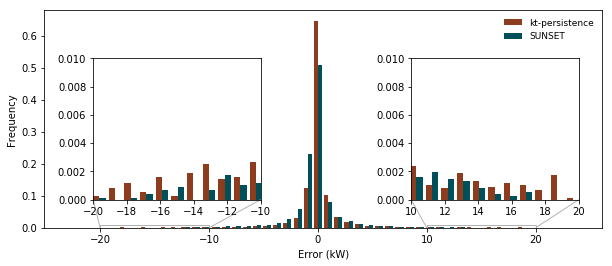

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig,ax = plt.subplots()
sunset_error = - pv_pred_test + pv_pred_test_sunset
ktpers_error = - pv_pred_test + pv_pred_test_ktpers

n, bins, patches = ax.hist([ktpers_error,sunset_error], 50, density=1, label = ['kt-persistence','SUNSET'])


ax.set_ylabel('Frequency')
ax.set_xlabel('Error (kW)')

fig.set_size_inches(10, 4)
ax.legend()

# Inset of the underprediction region
axins1 = inset_axes(ax, width = '100%', height = '100%',loc = 2, bbox_to_anchor = [0.08, 0.15, 0.3, 0.65],
                   bbox_transform=ax.transAxes)

axins1.hist([ktpers_error,sunset_error], 50, density=1, label = ['kt-persistence','SUNSET'])
axins1.set_xlim(-20, -10)
axins1.set_ylim(0, 0.01)

mark_inset(ax, axins1, loc1=3, loc2=4, ec="0.7")

# Inset of the overprediction region
axins2 = inset_axes(ax, width = '100%', height = '100%',loc = 2, bbox_to_anchor = [0.65, 0.15, 0.3, 0.65],
                   bbox_transform=ax.transAxes)

axins2.hist([ktpers_error,sunset_error], 50, density=1, label = ['kt-persistence','SUNSET'])
axins2.set_xlim(10, 20)
axins2.set_ylim(0, 0.01)

mark_inset(ax, axins2, loc1=3, loc2=4, ec="0.7")


plt.savefig(os.path.join(output_folder,'error_dist.pdf'), bbox_inches = 'tight',dpi = 600)
plt.show()


## 2.1 Different Input: Image and Output history

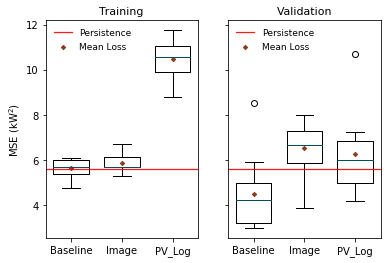

In [12]:
# Compare the training and validation loss boxchart for several model

model_name = ['CNN_1.0_Baseline','CNN_1.0_Pred_Image','CNN_1.0_Pred_PVlog']
model_label = ['Baseline','Image', 'PV_Log']

# Compare the rRMSE between this model and baseline model
f,axarr = plt.subplots(1,2,sharey = True)
set_name = ['Training','Validation']
best_loss = np.zeros((len(model_name),num_rep))

for i in range(len(set_name)):
    for j in range(len(model_name)):
        output_folder_model = os.path.join('models',model_name[j])
        best_loss[j] = find_best_loss(output_folder_model)[i]

    axarr[i].boxplot(best_loss.T,labels = model_label,widths = 0.7)

    axarr[i].set_title(set_name[i])
    axarr[i].grid(False)
    axarr[i].axhline(y=ktpers_mse_trainval,color= 'r',linewidth =1.25, alpha = 0.9,label = "Persistence")
    
    # Plot the mean loss
    mean_loss = np.mean(best_loss,axis = 1)
    axarr[i].scatter(np.arange(1,len(model_name)+1),mean_loss, marker = 'D', label = 'Mean Loss')
    axarr[i].legend(loc = 'upper left')

axarr[0].set_ylabel('MSE $(\mathrm{kW}^2)$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.savefig(os.path.join(output_folder,'Loss_different_input.pdf'), bbox_inches = 'tight')
plt.show()

## 2.2 Different model structure

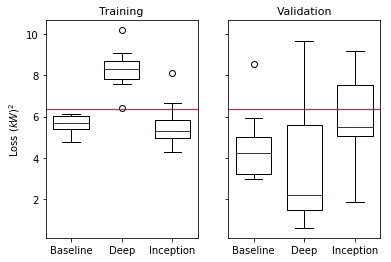

In [13]:
# Compare the training and validation loss boxchart for several model

model_name = ['CNN_1.0_Baseline','CNN_1.0_Baseline_Deep','TwoStep_1.0_Persistence_Inception']
model_label = ['Baseline','Deep', 'Inception']

# Compare the rRMSE between this model and baseline model
f,axarr = plt.subplots(1,2,sharey = True)
set_name = ['Training','Validation']
best_loss = np.zeros((len(model_name),num_rep))

for i in range(len(set_name)):
    for j in range(len(model_name)):
        output_folder_model = os.path.join('models',model_name[j])
        best_loss[j] = find_best_loss(output_folder_model)[i]

    axarr[i].boxplot(best_loss.T,labels = model_label,widths = 0.7)

    axarr[i].set_title(set_name[i])
    axarr[i].grid(False)
    axarr[i].axhline(y=pers_mse_trainval,color= 'r',linewidth =1.25, alpha = 0.9)

axarr[0].set_ylabel('Loss $(kW)^2$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.savefig(os.path.join(output_folder,'Loss_different_model.png'),dpi = 1200, bbox_inches = 'tight')
plt.show()

## 2.3 Sampling Frequency - median and mean

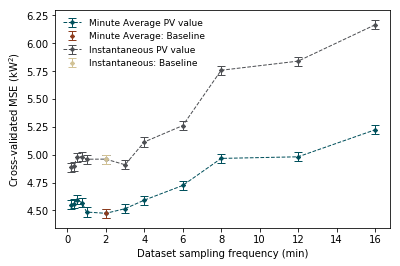

In [14]:
sampling_interval_all = [1/6,1/3, 1/2, 3/4, 1,2,3,4,6,8,12,16]
sampling_interval_labels = ['1/6','1/3', '1/2', '3/4', '1','2','3','4','6','8','12','16']

# Sensitivity plot on resolution
# Restore loss history of the minutely average experiment
val_loss_avg = np.load(os.path.join('models','CNN_1.0_Sampling_Frequency_Ave','val_loss.npy'))
val_best_avg = find_best_multiexp(val_loss_avg)

# restore loss history of instantaneus experiment
val_loss_instant = np.load(os.path.join('models','CNN_1.0_Sampling_Frequency_Instant','val_loss.npy'))
val_best_instant = find_best_multiexp(val_loss_instant)

# Plot the performance of the minutely average series
plt.errorbar(sampling_interval_all,np.mean(val_best_avg,axis=1),label = 'Minute Average PV value', fmt = '--D',
            color = 'C1', yerr = mean_loss_std, capsize= 4)
baseline_idx = sampling_interval_all.index(baseline_freq)
plt.errorbar(baseline_freq, np.mean(val_best_avg,axis=1)[baseline_idx], color = 'C0', fmt = 'D',
             label = 'Minute Average: Baseline', yerr = mean_loss_std, capsize= 4)

# Show the performance of the instantaneous series
plt.errorbar(sampling_interval_all,np.mean(val_best_instant,axis=1),label = 'Instantaneous PV value',fmt = '--D', 
            color = 'C3', yerr = mean_loss_std, capsize= 4)
plt.errorbar(baseline_freq, np.mean(val_best_instant,axis=1)[baseline_idx], color = 'C4',fmt = 'D',
             label = 'Instantaneous: Baseline', yerr = mean_loss_std, capsize= 4)

# label and legend
plt.xlabel('Dataset sampling frequency (min)')
plt.ylabel('Cross-validated MSE $(\mathrm{kW}^2)$')

plt.legend()
plt.savefig(os.path.join(output_folder,'val_loss_instant_vs_ave.pdf'), bbox_inches = 'tight')
plt.show()

##  2.4 Lag Term Configuration
Graphical representation of the lag term experiments

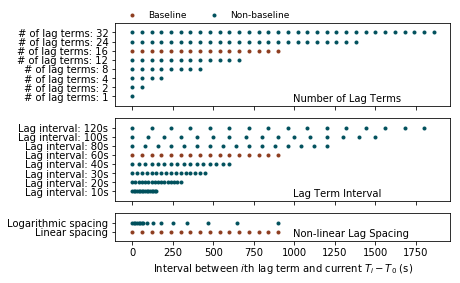

In [15]:
## Set up a three panel plot, for the three experiment 
fig, axarr = plt.subplots(3,1, sharex = True,
                         gridspec_kw = {'height_ratios':[3,3,1]})

## Number of lag terms
num_log_all = [1,2,4,8,12,16,24,32]
ax = axarr[0]
for i,num_log in enumerate(num_log_all):
    if num_log ==16:
        color = 'C0'
    else:
        color = 'C1'
    ax.scatter(np.arange(num_log)*60, np.ones(num_log)*(i+1),color = color)
ax.set_ylim(0,len(num_log_all)+1)

ax.set_yticks(np.arange(1,len(num_log_all)+1))
tick_labels = ['# of lag terms: '+str(num_log) for num_log in num_log_all]
ax.set_yticklabels(tick_labels)
ax.text(0.53,0.05,'Number of Lag Terms',transform=ax.transAxes)
    
## Interval of lag terms
log_interval_all = [10,20,30,40,60,80,100,120]
ax = axarr[1]
for i,log_interval in enumerate(log_interval_all):
    if log_interval ==60:
        color = 'C0'
    else:
        color = 'C1'
    ax.scatter(np.arange(16)*log_interval, np.ones(16)*(i+1), color = color)
ax.set_ylim(0,len(log_interval_all)+1)

ax.set_yticks(np.arange(1,len(log_interval_all)+1))
tick_labels = ['Lag interval: '+str(log_interval) + 's'
               for log_interval in log_interval_all]
ax.set_yticklabels(tick_labels)
ax.text(0.53,0.05,'Lag Term Interval',transform=ax.transAxes)

## Non linear spacing of lag terms
ax = axarr[2]
log_spacing_all = [0, 10, 20, 30, 40, 50, 60, 70,
                    90, 130, 180, 250, 340, 470, 650, 900]
ax.scatter(np.arange(16)*60,np.ones(16), label = 'Baseline')
ax.scatter(log_spacing_all, np.ones(16)*2, label = 'Non-baseline')
ax.set_ylim(0,3)

ax.set_yticks([1,2])
tick_labels = ['Linear spacing', 'Logarithmic spacing']
ax.set_yticklabels(tick_labels)
ax.text(0.53,0.15,'Non-linear Lag Spacing',transform=ax.transAxes)

## Add in xaxis label and legend
ax.set_xlabel('Interval between $i$th lag term and current $T_i-T_0$ (s)')
ax.legend(bbox_to_anchor = [0,8.7], loc = 'upper left', ncol = 2)

# Save figure
plt.savefig(os.path.join(output_folder,'lag_term_exp_illustration.pdf'), bbox_inches = 'tight')
plt.show()

### 2.4.1 Number and Interval of Lag terms

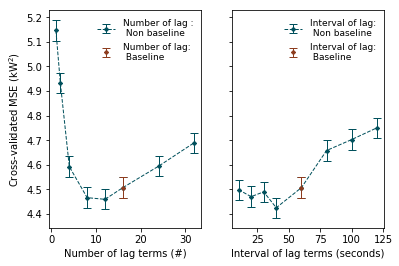

In [16]:
# Load in the validation loss
val_loss= np.load(os.path.join('models','CNN_1.0_Num_Log','val_loss.npy'))
val_best_loss = find_best_multiexp(val_loss)
base_loss = find_best_loss(os.path.join('models','CNN_1.0_Baseline'))[1]

fig, [ax1,ax2] = plt.subplots(1,2, sharey = True)

# Substitute into base loss
baseline_idx = num_log_all.index(baseline_num_lag)
val_best_loss[baseline_idx,:] = base_loss

# Plotting
ax1.errorbar(num_log_all,np.mean(val_best_loss, axis=1),yerr = mean_loss_std,fmt = '--D', color = 'C1',
             label = 'Number of lag :\n Non baseline')

# Show the baseline performance in a different color
baseline_hdl = ax1.errorbar(baseline_num_lag, np.mean(val_best_loss,axis=1)[baseline_idx], fmt = 'D', color = 'C0',
                            label = 'Number of lag:\n Baseline', yerr = mean_loss_std)

ax1.legend()
ax1.set_xlabel('Number of lag terms (#)')
ax1.set_ylabel('Cross-validated MSE $(\mathrm{kW}^2)$')

# Load in the validation loss
val_loss= np.load(os.path.join('models','CNN_1.0_Log_Interval','val_loss.npy'))
val_best_loss = find_best_multiexp(val_loss)

# Substitute into base loss
baseline_idx = log_interval_all.index(baseline_interval)
val_best_loss[baseline_idx,:] = base_loss

ax2.errorbar(log_interval_all,np.mean(val_best_loss, axis=1),yerr = mean_loss_std, fmt = '--D', color = 'C1',
             label = 'Interval of lag:\n Non baseline')

# Show the baseline performance in a different color

baseline_hdl = ax2.errorbar(baseline_interval, np.mean(val_best_loss,axis=1)[baseline_idx], color = 'C0', fmt = 'D',
                            label = 'Interval of lag:\n Baseline', yerr = mean_loss_std)

ax2.legend()
ax2.set_xlabel('Interval of lag terms (seconds)')

## Confidence interval. Not used right now
# import scipy.stats
# confidence_interval = np.zeros((len(num_log_all),2))
# for i in range(len(num_log_all)):
#     confidence_interval[i] = scipy.stats.t.interval(0.95, len(val_best[i])-1, loc=np.mean(val_best[i]), scale=scipy.stats.sem(val_best[i]))
# ax1.fill_between(num_log_all,confidence_interval[:,0],confidence_interval[:,1], color = 'grey', alpha = 0.5)

plt.savefig(os.path.join(output_folder,'Num_Interval_lag.pdf'), bbox_inches = 'tight')
plt.show()

### 2.4.2 Non-linear Spacing of lag terms

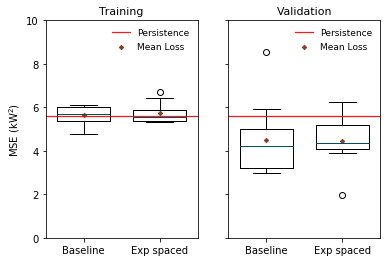

In [18]:
# Compare the training and validation loss boxchart with baseline model

baseline_model_name = 'CNN_1.0_Baseline'
output_folder_baseline = os.path.join('models',baseline_model_name)

best_loss_baseline = find_best_loss(output_folder_baseline)
best_loss_curr = find_best_loss(os.path.join('models','CNN_1.0_Log_Spaced'))

# Compare the rRMSE between this model and baseline model
f,axarr = plt.subplots(1,2,sharey = True)
set_name = ['Training','Validation']
model_label = ['Baseline','Exp spaced']

for i in range(len(axarr)):
    best_loss = np.vstack((best_loss_baseline[i],best_loss_curr[i]))
    axarr[i].boxplot(best_loss.T, labels = model_label,widths = 0.7)
    
    axarr[i].set_title(set_name[i])
    axarr[i].grid(False)
    axarr[i].axhline(y=ktpers_mse_trainval,color= 'r',linewidth =1.25, alpha = 0.9, label = 'Persistence')
    
    # Plot the mean loss
    mean_loss = np.mean(best_loss,axis = 1)
    axarr[i].scatter(np.arange(1,len(model_label)+1),mean_loss, marker = 'D', label = 'Mean Loss')
    axarr[i].legend(loc = 'upper right')

axarr[0].set_ylabel('MSE $(\mathrm{kW}^2)$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.ylim(0,10)
plt.savefig(os.path.join(output_folder,'non_linear_spacing.pdf'),bbox_inches = 'tight')
plt.show()

# 3. Prediction time series comparison
(Under Construction)

FileNotFoundError: [Errno 2] No such file or directory: 'data_pred\\pv_pred_test.npy'

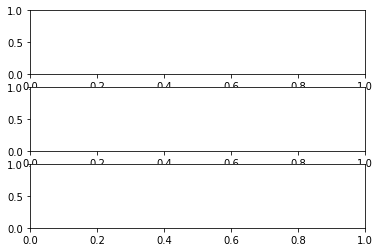

In [13]:
# Compare the time series between Huang and Y2E2
f,axarr = plt.subplots(3,1)
caption = ['Input: Image','Input: PV_log','Input: Image & PV_log']
output_folder_pred = ['CNN_1.0_Pred_Image','CNN_1.0_Pred_PVlog','CNN_1.0_Pred_Image_PVlog']
y_test = np.load(os.path.join('data_pred','pv_pred_test.npy'))

for i in range(3):
    pred_y_value = np.load(os.path.join('models',output_folder_pred[i],"pred_test.npy"))
    axarr[i].plot(y_test, label='Actual pv output', alpha = 0.9,linewidth = 1)
    axarr[i].plot(pred_y_value, label='Predicted pv output',alpha = 0.9, linewidth = 1)
    axarr[i].set_ylim(0,35)
    text_yloc = axarr[i].get_ylim()[1]*0.83+axarr[i].get_ylim()[0]*0.17
    axarr[i].text(0,text_yloc,caption[i],fontsize = 9)
    axarr[i].set_ylabel('Output (kW)')

axarr[2].set_xlabel('Image index')
plt.legend(bbox_to_anchor =[1,3.7],loc='upper right',ncol = 2)

plt.gcf().set_size_inches(4.5,6)
plt.savefig(os.path.join(output_folder,'time_series_comparison.png'),bbox_inches = 'tight')
plt.show()

# A. Suppplementary

In [ ]:
# Load in the validation loss
val_loss= np.load(os.path.join('models','CNN_1.0_Num_Log','val_loss.npy'))
val_best_loss = find_best_multiexp(val_loss)

# Plotting
plt.errorbar(num_log_all,np.mean(val_best_loss, axis=1),yerr = mean_loss_std,fmt = '--D', color = 'C1',
             label = 'Non baseline')

# Show the baseline performance in a different color
baseline_idx = num_log_all.index(baseline_num_lag)
baseline_hdl = plt.errorbar(baseline_num_lag, np.mean(val_best_loss,axis=1)[baseline_idx], fmt = 'D', color = 'C0',
                            label = 'Baseline', yerr = mean_loss_std)

plt.legend()
plt.xlabel('Number of lag terms (#)')
plt.ylabel('Cross-validated MSE $(\mathrm{kW}^2)$')

## Confidence interval. Not used right now
# import scipy.stats
# confidence_interval = np.zeros((len(num_log_all),2))
# for i in range(len(num_log_all)):
#     confidence_interval[i] = scipy.stats.t.interval(0.95, len(val_best[i])-1, loc=np.mean(val_best[i]), scale=scipy.stats.sem(val_best[i]))
# plt.fill_between(num_log_all,confidence_interval[:,0],confidence_interval[:,1], color = 'grey', alpha = 0.5)

plt.savefig(os.path.join(output_folder,'Num_lag.pdf'),bbox_inches = 'tight')
plt.show()

In [ ]:
# Load in the validation loss
val_loss= np.load(os.path.join('models','CNN_1.0_Num_Log','val_loss.npy'))
val_best_loss = find_best_multiexp(val_loss)
base_loss = find_best_loss(os.path.join('models','CNN_1.0_Baseline'))[1]

fig, ax1 = plt.subplots()

# Substitute into base loss
baseline_idx = num_log_all.index(baseline_num_lag)
val_best_loss[baseline_idx,:] = base_loss

# Plotting
ax1.errorbar(num_log_all,np.mean(val_best_loss, axis=1),yerr = mean_loss_std,fmt = '--D', color = 'C1',
             label = 'Number of lag :\n Non baseline')

# Show the baseline performance in a different color
baseline_hdl = ax1.errorbar(baseline_num_lag, np.mean(val_best_loss,axis=1)[baseline_idx], fmt = 'D', color = 'C0',
                            label = 'Number of lag:\n Baseline', yerr = mean_loss_std)

ax1.legend(loc = 'lower right')
ax1.set_xlabel('Number of lag terms (#)')
ax1.set_ylabel('Cross-validated MSE $(\mathrm{kW}^2)$')


ax2 = ax1.twiny()
# Load in the validation loss
val_loss= np.load(os.path.join('models','CNN_1.0_Log_Interval','val_loss.npy'))
val_best_loss = find_best_multiexp(val_loss)

# Substitute into base loss
baseline_idx = log_interval_all.index(baseline_interval)
val_best_loss[baseline_idx,:] = base_loss

ax2.errorbar(log_interval_all,np.mean(val_best_loss, axis=1),yerr = mean_loss_std, fmt = '--D', color = 'C2',
             label = 'Interval of lag:\n Non baseline')

# Show the baseline performance in a different color

baseline_hdl = ax2.errorbar(baseline_interval, np.mean(val_best_loss,axis=1)[baseline_idx], color = 'C4', fmt = 'D',
                            label = 'Interval of lag:\n Baseline', yerr = mean_loss_std)

ax2.legend()
ax2.set_xlabel('Interval of lag terms (seconds)')

## Confidence interval. Not used right now
# import scipy.stats
# confidence_interval = np.zeros((len(num_log_all),2))
# for i in range(len(num_log_all)):
#     confidence_interval[i] = scipy.stats.t.interval(0.95, len(val_best[i])-1, loc=np.mean(val_best[i]), scale=scipy.stats.sem(val_best[i]))
# ax1.fill_between(num_log_all,confidence_interval[:,0],confidence_interval[:,1], color = 'grey', alpha = 0.5)

plt.savefig(os.path.join(output_folder,'Num_Interval_lag.pdf'),bbox_inches = 'tight')
plt.show()

In [ ]:
# Load in the validation loss
val_loss= np.load(os.path.join('models','CNN_1.0_Log_Interval','val_loss.npy'))
val_best_loss = find_best_multiexp(val_loss)

# Plotting
plt.errorbar(log_interval_all,np.mean(val_best_loss, axis=1),yerr = mean_loss_std)

# Show the baseline performance in a different color
baseline_idx = log_interval_all.index(baseline_interval)
baseline_hdl = plt.errorbar(baseline_interval, np.mean(val_best_loss,axis=1)[baseline_idx], color = 'C1', fmt = 'D',
                            label = 'Baseline', yerr = mean_loss_std)
plt.legend(handles = [baseline_hdl])

plt.xlabel('Interval of lag terms (seconds)')
plt.ylabel('Cross-validated MSE $(\mathrm{kW}^2)$')

## Confidence interval. Not used right now
# import scipy.stats
# confidence_interval = np.zeros((len(num_log_all),2))
# for i in range(len(num_log_all)):
#     confidence_interval[i] = scipy.stats.t.interval(0.95, len(val_best[i])-1, loc=np.mean(val_best[i]), scale=scipy.stats.sem(val_best[i]))
# plt.fill_between(num_log_all,confidence_interval[:,0],confidence_interval[:,1], color = 'grey', alpha = 0.5)

plt.savefig(os.path.join(output_folder,'Interval_lag.pdf'),bbox_inches = 'tight')
plt.show()